In [1]:
from EffectiveXGBoost import *
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn.objects as so

path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

survey_df = extract_dataset(path_url, file_name, dataset)
final_df = prep_data(survey_df)

pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X, y = prepX_y(survey_df, 'Q6')

sur_X_train, sur_X_test, sur_y_train, sur_y_test = (model_selection
                                    .train_test_split(X, y, 
                                                      test_size=.3, 
                                                      random_state=42, 
                                                      stratify=y)
                                                        )

X_train = pline.fit_transform(sur_X_train, sur_y_train)
X_test = pline.transform(sur_X_test)

stump_dt = tree.DecisionTreeClassifier(max_depth=1)
X_train = pline.fit_transform(sur_X_train)
stump_dt.fit(X_train, sur_y_train)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:58: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  all_df = pd.read_csv(z.open(dataset))


DecisionTreeClassifier(max_depth=1)

In [2]:
X_test = pline.transform(sur_X_test)
stump_dt.score(X_test, sur_y_test)

0.6243093922651933

## 8.1 Ensembles with Bagging
An ensemble is a group
of models that aggregate results (in some ways) to prevent overfitting. The ensembling technique used by
random forests is called _bagging_ or _bootstrap aggregating_. The _bootstrapping_ part says it creates multiple versions of a predictor by training it on different subsets of the training data. These subsets are obtained by randomly sampling the training data with replacement. The _aggregation_ part says it takes the predictions from each predictor are then combines by taking a majority vote (in the case of classification) or by averaging (in the case of regression).

In the context of Random Forests, bagging is used to create multiple decision trees, each trained on a different bootstrap sample of the training data. The predictions from each tree are then combined to produce a final prediction. This process helps to reduce the variance of the model and improve its predictive performance.

Bootstrapping is a technique used to create multiple bootstrap samples of the training data by randomly sampling with replacement. Each tree in the forest is then trained on a different bootstrap sample of the data.

Column subsampling, on the other hand, is a technique used to randomly select a subset of features to consider at each split point in the tree building process. This introduces randomness into the tree building process and helps to reduce the correlation between trees in the forest.

Both bootstrapping and column subsampling are used in Random Forests to introduce randomness into the model and improve its performance. However, they are two separate techniques that operate on different aspects of the data (bootstrapping operates on the rows of the data, while column subsampling operates on the columns).

## 8.2 Scikit-learn Random Forest
Here is a random forest model created with scikit-learn.

The `random_state` parameter in the `ensemble.RandomForestClassifier` function is used to control the randomness of the model. Random Forests use randomness in several ways, such as when creating bootstrap samples of the data and when selecting features for splits in the tree building process. The `random_state` parameter allows you to set a seed for the random number generator used by the model, which makes the randomness deterministic.

Setting the `random_state` to a fixed value (such as 42 in this case) ensures that the model will produce the same results every time it is run with the same data and parameters. This can be useful for reproducibility and debugging purposes. If you don’t set the `random_state`, the model will produce different results each time it is run, even if the data and parameters are the same.

It’s important to note that setting the `random_state` does not affect the performance of the model in any way. It simply makes the randomness deterministic, which can be useful in certain situations.

In [3]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, sur_y_train)
rf.score(X_test, sur_y_test)

0.7237569060773481

The `.get_params` method will print out all the hyperparameters of the model and there we can see the total number of trees it created.

In [4]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

We have 100 trees (from the `'n_estimators'`). To explore each
tree, we can locate them under the `.estimators_ attribute`.

In scikit-learn, any attribute that ends with an underscore (for eg `.estimators_`) is usually created during the call to the `.fit` method. The `.estimators_` attribute has the list of trees. To validate the number of trees in our model...

In [5]:
 len(rf.estimators_)

100

Every 'estimator' is a decision tree. Let us slice and view the first (or last) tree created.

In [6]:
print(rf.estimators_[0])
print(rf.estimators_[-1])


DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)
DecisionTreeClassifier(max_features='sqrt', random_state=134489564)


Below is the visualization for tree 0 limited to depth
two so we can read it.

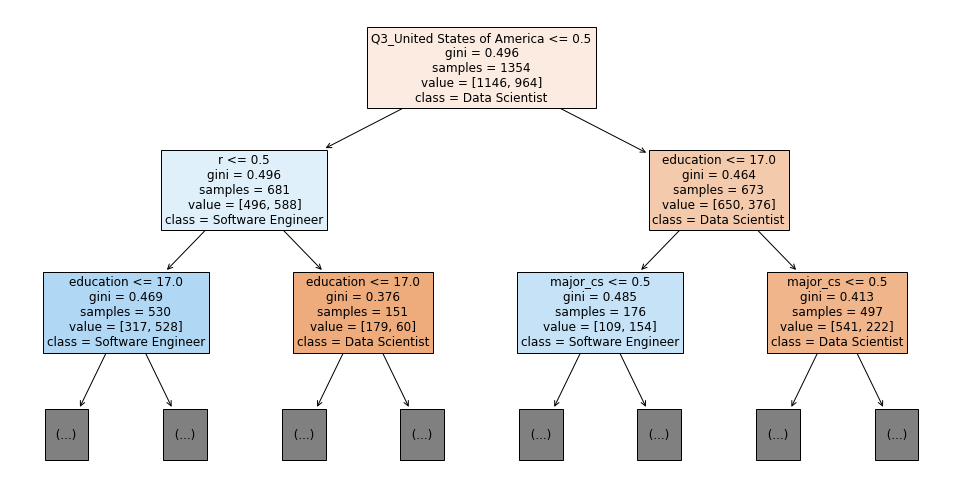

In [7]:
fig, ax = plt.subplots(figsize=(17, 9))

tree.plot_tree(rf.estimators_[0], feature_names=[c for c in X_train.columns],
    filled=True, class_names=rf.classes_, ax=ax,
    max_depth=2, fontsize=12);

## 8.3 XGBoost Random Forest
As the XGBoost library also has its own implementation of random forest, let us also now view its implementation, remembering that XGBoost dislikes string labels a lot.

In [8]:
import xgboost as xgb
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(sur_y_train)
y_test = label_encoder.transform(sur_y_test)

rf_xgb = xgb.XGBRFClassifier(random_state=42)
rf_xgb.fit(X_train, y_train)
rf_xgb.score(X_test, y_test)

0.7458563535911602

Inspecting the hyperparameters if this random forests reveals to us that XGBoost uses different hyperparameters in random forests with that of scikit-learn.

In [9]:
rf_xgb.get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 100,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

We will now visualize the first tree with the `plot_tree` function of XGBoost.

In [10]:
# fig, ax = plt.subplots(figsize=(6,12), dpi=600)
# xgb.plot_tree(rf_xgb, num_trees=0, ax=ax, size='1,1')

my_image_export(rf_xgb, n_trees=0, filename='img/rf_xg_kag.dot', 
              title='First Random Forest Tree', direction='LR')


The `dtreeviz` library and limit the depth to 2 (`depth_range_to_display=[0,2]`) so we could visualize a part of it.

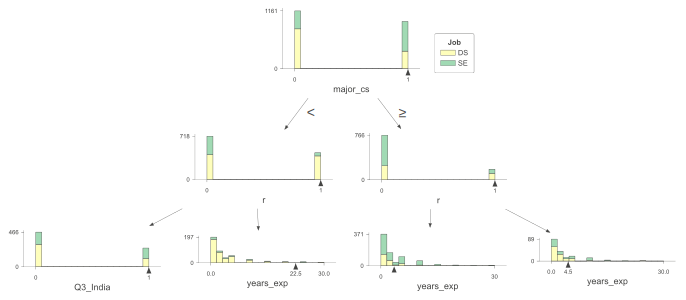

In [11]:
import dtreeviz
viz = dtreeviz.model(rf_xgb, X_train=X_train,
    y_train=y_train,
    target_name='Job', feature_names=list(X_train.columns),
    class_names=['DS', 'SE'], tree_index=0)
viz.view(depth_range_to_display=[0,2])

## 8.4 Random Forest Hyperparameters

Here are most of the hyperparameters for random forests (created with the XGBoost library).

* `'max_depth=6 '`- Tree depth. Range [1-large number]
* `'max_leaves=0'` - Number of leaves in a tree. (Not supported by tree_method='exact'). A
value of 0 means no limit, otherwise, the range is [2-large number]
* `'min_child_weight=1'` - Minimum sum of hessian (weight) needed in a child. The larger the
value, the more conservative. Range [0,∞]
`'grow_policy="depthwise"'` - (Only supported with tree_method set to 'hist', 'approx', or
'gpu_hist'. Split nodes closest to root. Set to "lossguide" (with max_depth=0) to mimic
LightGBM behavior.
* `'tree_method="auto" '`- Use "hist" to use histogram bucketing and increase performance.
"auto" heuristic:
– 'exact' for small data
– 'approx' for larger data
– 'hist' for histograms (limit bins with max_bins (default 256))

Sampling hyperparameters. These work cumulatively. First by the tree, then by level, and
finally by the node.

* `'colsample_bytree=1'` - Subsample columns at each tree. Range (0,1]
* `'colsample_bylevel=1'` - Subsample columns at each level (from tree columns colsample_bytree).
Range (0,1]
* `'colsample_bynode=1'` - Subsample columns at each node split (from tree columns colsample_bytree). Range (0,1]
* `'subsample=1'` - Sample portion of training data (rows) before each boosting round. Range (0,1]
* `'sampling_method='uniform''` - Sampling method. 'uniform' for equal probability. gradient_based sample is proportional to the regularized absolute value of gradients (only supported by tree_method="gpu_hist".

Categorical data hyperparameters. Use the `'enable_categorical=True'` parameter and set columns to _pandas_ categoricals (`.astype('category')`)

* `'max_cat_to_onehot=4'` - Upper threshold for using one-hot encoding for categorical features. Use one-hot encoding when the number of categories is less than this number.
* `'max_cat_threshold=64'` - Maximum number of categories to consider for each split
* `'n_estimators=100'` - Number of trees. Range [1, large number]
* `'early_stopping_rounds=None'` - Stop creating new trees if eval_metric score has not improved after n rounds. Range [1,∞]
* `'eval_metric'` - Metric for evaluating validation data.
* objective - Learning objective to optimize the fit of the model to data during training.
    - Classification objectives
         * `'binary:logistic'` - Default classification objective. Outputs probability
         
Regularization hyperparameters.
* learning_rate=.3 - After each boosting round, multiply weights to make it more
conservative. Lower is more conservative. Range (0,1]
* gamma=0 - Minimum loss required to make a further partition. Larger is more
conservative. Range [0,∞]
* reg_alpha=0 - L1 regularization. Increasing will make it more conservative.
* reg_lambda=1 - L2 regularization. Increasing will make it more conservative. Imbalanced data hyperparameters.
* scale_pos_weight=1 - Consider (count negative) / (count positive) for imbalanced classes. Range (0, large number)
* max_delta_step=0 - Maximum delta step for leaf output. It might help with imbalanced classes. Range [0,∞]

## 8.5 Training the Number of Trees in the Forest
Let’s try out a few different values for n_estimators and inspect what happens to the accuracy
of our random forest model.

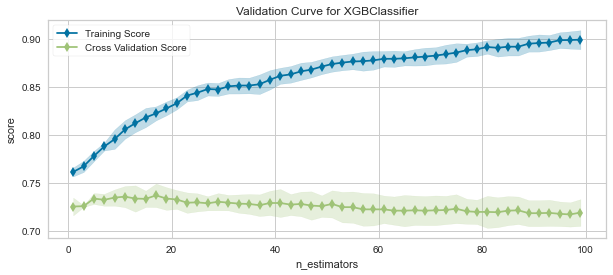

In [12]:
from yellowbrick.model_selection import validation_curve
fig, ax = plt.subplots(figsize=(10,4))
viz = validation_curve(xgb.XGBClassifier(random_state=42), 
                       X=pd.concat([X_train, X_test], axis='index'),
                       y=np.concatenate([y_train, y_test]),
                       param_name='n_estimators', param_range=range(1, 100, 2),
                       scoring='accuracy', cv=3, ax=ax)

A quick check shows that it
performs slightly better than the out-of-the-box model. I will choose the simpler model when
given a choice between models that perform similarly. In this case, a model with 99 trees
appears to perform similarly but is more complex, so I go with the simpler model

In [13]:
rf_xgb29 = xgb.XGBRFClassifier(random_state=42, n_estimators=29)
rf_xgb29.fit(X_train, y_train)
rf_xgb29.score(X_test, y_test)


0.7546961325966851